## Problem statement:
To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [ ]:
#import the required libraries
import pathlib
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

from tensorflow.keras.preprocessing.image import load_img

from glob import glob

In [ ]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive

import shutil

# Define the path to the folder you want to delete
folder_path = 'Skin cancer ISIC The International Skin Imaging Collaboration'

# Use shutil.rmtree to delete the folder and its contents
shutil.rmtree(folder_path)

drive.flush_and_unmount()

drive.mount('/content/gdrive', force_remount=True)





Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [ ]:
# In case of google drive
!unzip -o -q "/content/gdrive/MyDrive/ColabNotebooks/CNN_assignment.zip"

In [ ]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


In [ ]:
#list directory in train folder
dir_train = os.listdir(data_dir_train)
dir_train.sort()
dir_train

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

In [ ]:
#both test & train have same folders (disease folder ), now check the no. of datapoints in each folder

#total train dataset
total_train_data = len(list(data_dir_train.glob("*/*.jpg")))
total_train_data

2239

In [ ]:
#total test dataset
total_test_data = len(list(data_dir_test.glob("*/*.jpg")))
total_test_data

118

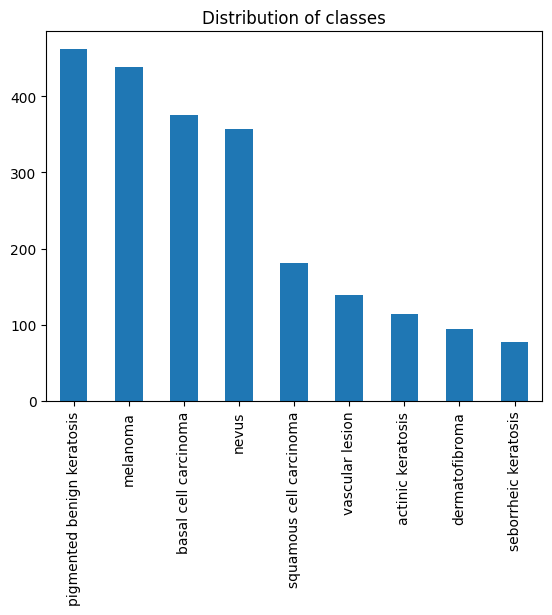

,Class,Count of Image
0,pigmented benign keratosis,462
1,seborrheic keratosis,77
2,actinic keratosis,114
3,squamous cell carcinoma,181
4,basal cell carcinoma,376
5,melanoma,438
6,nevus,357
7,vascular lesion,139
8,dermatofibroma,95


In [ ]:
def class_distribution_count(directory):
    train_path_list = list(directory.glob('*/*.jpg'))
    df=pd.DataFrame({"cancer_type":[str(x).split("/")[2] for x in train_path_list]})
    df['cancer_type'].value_counts().plot(kind='bar')
    plt.title("Distribution of classes")
    plt.show()

    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                                if os.path.isfile(os.path.join(path, name))]))

    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]

    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'Count of Image'])

df = class_distribution_count(data_dir_train)
df


### Create a dataset

Define some parameters for the loader:

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
def show_accuracy_pattern(history):
  # accuracy & loss graph
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(10,10))
  plt.subplot(1,2,1)
  plt.plot(epochs_range, acc, label = 'Training Accuracy')
  plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
  plt.legend(loc = 'lower right')
  plt.title('Training & Validation Accuracy')

  plt.subplot(1,2,2)
  plt.plot(epochs_range, loss, label = 'Training Loss')
  plt.plot(epochs_range, val_loss, label = 'Validation Loss')
  plt.legend(loc = 'upper right')
  plt.title('Training & Validation Loss')



### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

In [ ]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'training',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [ ]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'validation',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [ ]:
## for test set , creating only 1 batch
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test,
    seed=123,
    batch_size=118,
    image_size=(img_height,img_width)
)


Found 118 files belonging to 9 classes.


In [ ]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)
print(len(class_names))

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
9


In [ ]:
val_ds.class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

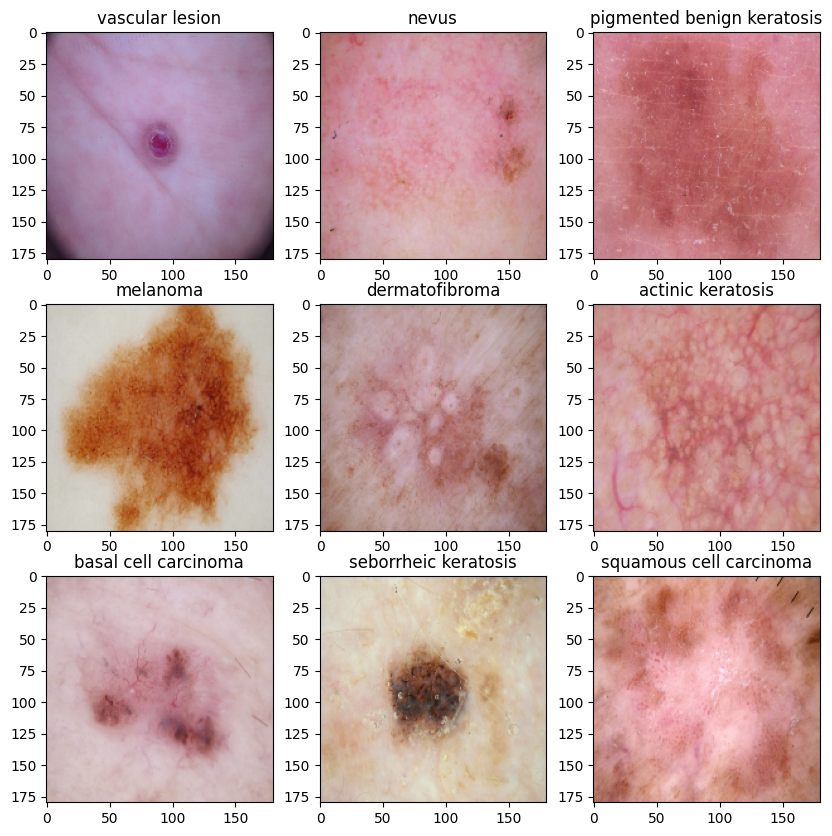

In [ ]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize

plot_idx=0
visited={}
visited_all=False
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(50):
  if not visited_all:
    for i in range(9):
      # print(images," | ",labels)
      # print(images.shape)
      # print(images[0].shape)
      # plt.figure(figsize=(20,20))
      if len(visited.keys())==9:
        visited_all=True
        break
      if class_names[labels[i]] in visited.keys():
        continue
      else:
        plt.subplot(3,3,plot_idx+1)
        plt.imshow(images[i].numpy().astype("uint8"));
        plt.title(class_names[labels[i]])
        visited[class_names[labels[i]]]="Y"
        plot_idx+=1
  else:
    break

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [ ]:
### Your code goes here
# Do all the possible playing with Hyperparameters to get the best model. See if you can get a model which
# is not overfitting or underfitting
# Write down proper insights about your model

num_classes = 9

model_1_base = Sequential([
                layers.Rescaling(1./255,input_shape=(img_height,img_width,3)),
                layers.Conv2D(16,3,padding='same',activation="relu"),
                layers.MaxPool2D((2,2),strides=2),


                layers.Conv2D(32,3,padding='same',activation="relu"),
                layers.MaxPool2D((2,2),strides=2),

                layers.Conv2D(64,3,padding='same',activation="relu"),
                layers.MaxPool2D((2,2),strides=2),

                layers.Flatten(),
                layers.Dense(64,activation="relu"),
                layers.Dense(num_classes)
])


### Compile the model
Choose an appropirate optimiser and loss function for model training

In [ ]:
### Todo, choose an appropirate optimiser and loss function
# model_1_base.compile(optimizer='your_optimser',loss=your_loss_function_goes_here,metrics=['accuracy'])

model_1_base.compile(optimizer="adam",loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics = ['accuracy'])

In [ ]:
# View the summary of all layers
model_1_base.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 45, 45, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 45, 45, 64)       

### Train the model

In [ ]:
epochs = 20
history = model_1_base.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 17s 118ms/step - loss: 2.0951 - accuracy: 0.1780 - val_loss: 1.9845 - val_accuracy: 0.2170
Epoch 2/20
56/56 [==============================] - 1s 22ms/step - loss: 1.9161 - accuracy: 0.2958 - val_loss: 1.8522 - val_accuracy: 0.3400
Epoch 3/20
56/56 [==============================] - 1s 20ms/step - loss: 1.6555 - accuracy: 0.4224 - val_loss: 1.4913 - val_accuracy: 0.4832
Epoch 4/20
56/56 [==============================] - 1s 21ms/step - loss: 1.4271 - accuracy: 0.5145 - val_loss: 1.5069 - val_accuracy: 0.5123
Epoch 5/20
56/56 [==============================] - 1s 21ms/step - loss: 1.3520 - accuracy: 0.5301 - val_loss: 1.4448 - val_accuracy: 0.5101
Epoch 6/20
56/56 [==============================] - 1s 22ms/step - loss: 1.2353 - accuracy: 0.5675 - val_loss: 1.3635 - val_accuracy: 0.5213
Epoch 7/20
56/56 [==============================] - 1s 22ms/step - loss: 1.2041 - accuracy: 0.5753 - val_loss: 1.3876 - val_accuracy: 0.5391
Epoch 8/20


### Visualizing training results

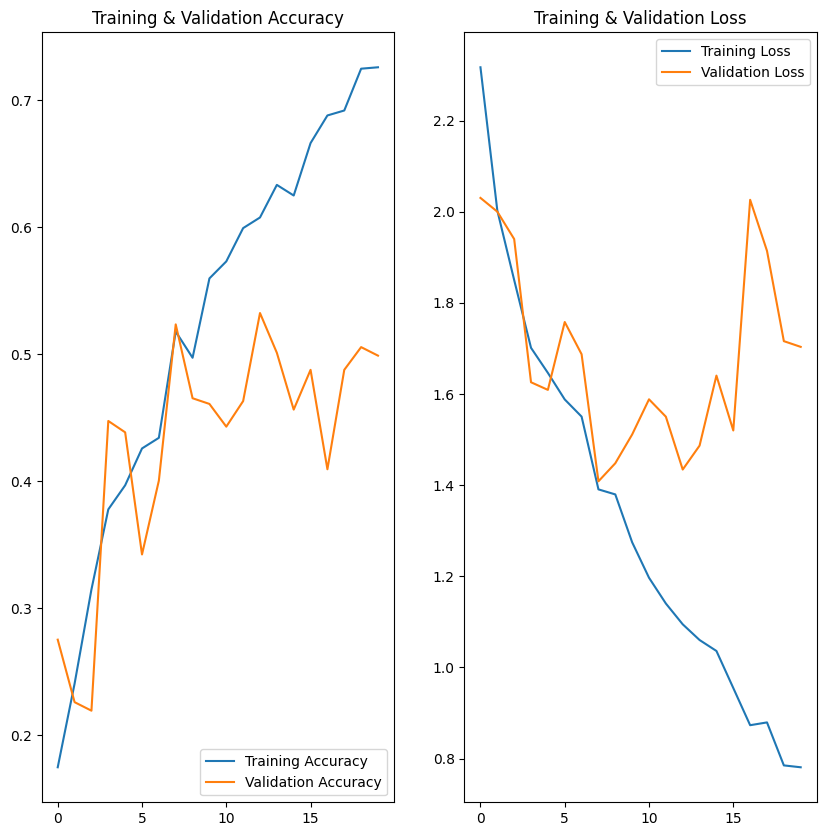

In [ ]:
show_accuracy_pattern(history)

# Observation - Overfitting

1.   Training Accuracy : Training Accuracy is high
2.   Validation Accuracy : Validation accuracy is low compared to the Training Accuracy so , its not a good model.
3.   Training Loss : Its decerasing
4.   Validation Loss : its increasing per epoch so not a good fit




# M2 Model ( With Augumentation)

In [ ]:
# data_augument = preprocessing.Rescaling(1./255)

augumentation_var = keras.Sequential([
                                      layers.experimental.preprocessing.RandomFlip(
                                                                                      mode="horizontal_and_vertical",
                                                                                      input_shape=(img_height,img_width,3)
                                                                                      ),
                                      layers.experimental.preprocessing.RandomRotation(
                                                                                        0.2,
                                                                                        fill_mode='reflect'
                                                                                        ),
                                      layers.experimental.preprocessing.RandomZoom(
                                                                                        height_factor=(0.2, 0.3),
                                                                                        width_factor=(0.2, 0.3),
                                                                                        fill_mode='reflect'
                                                                                  )
                                      ]
                                  )


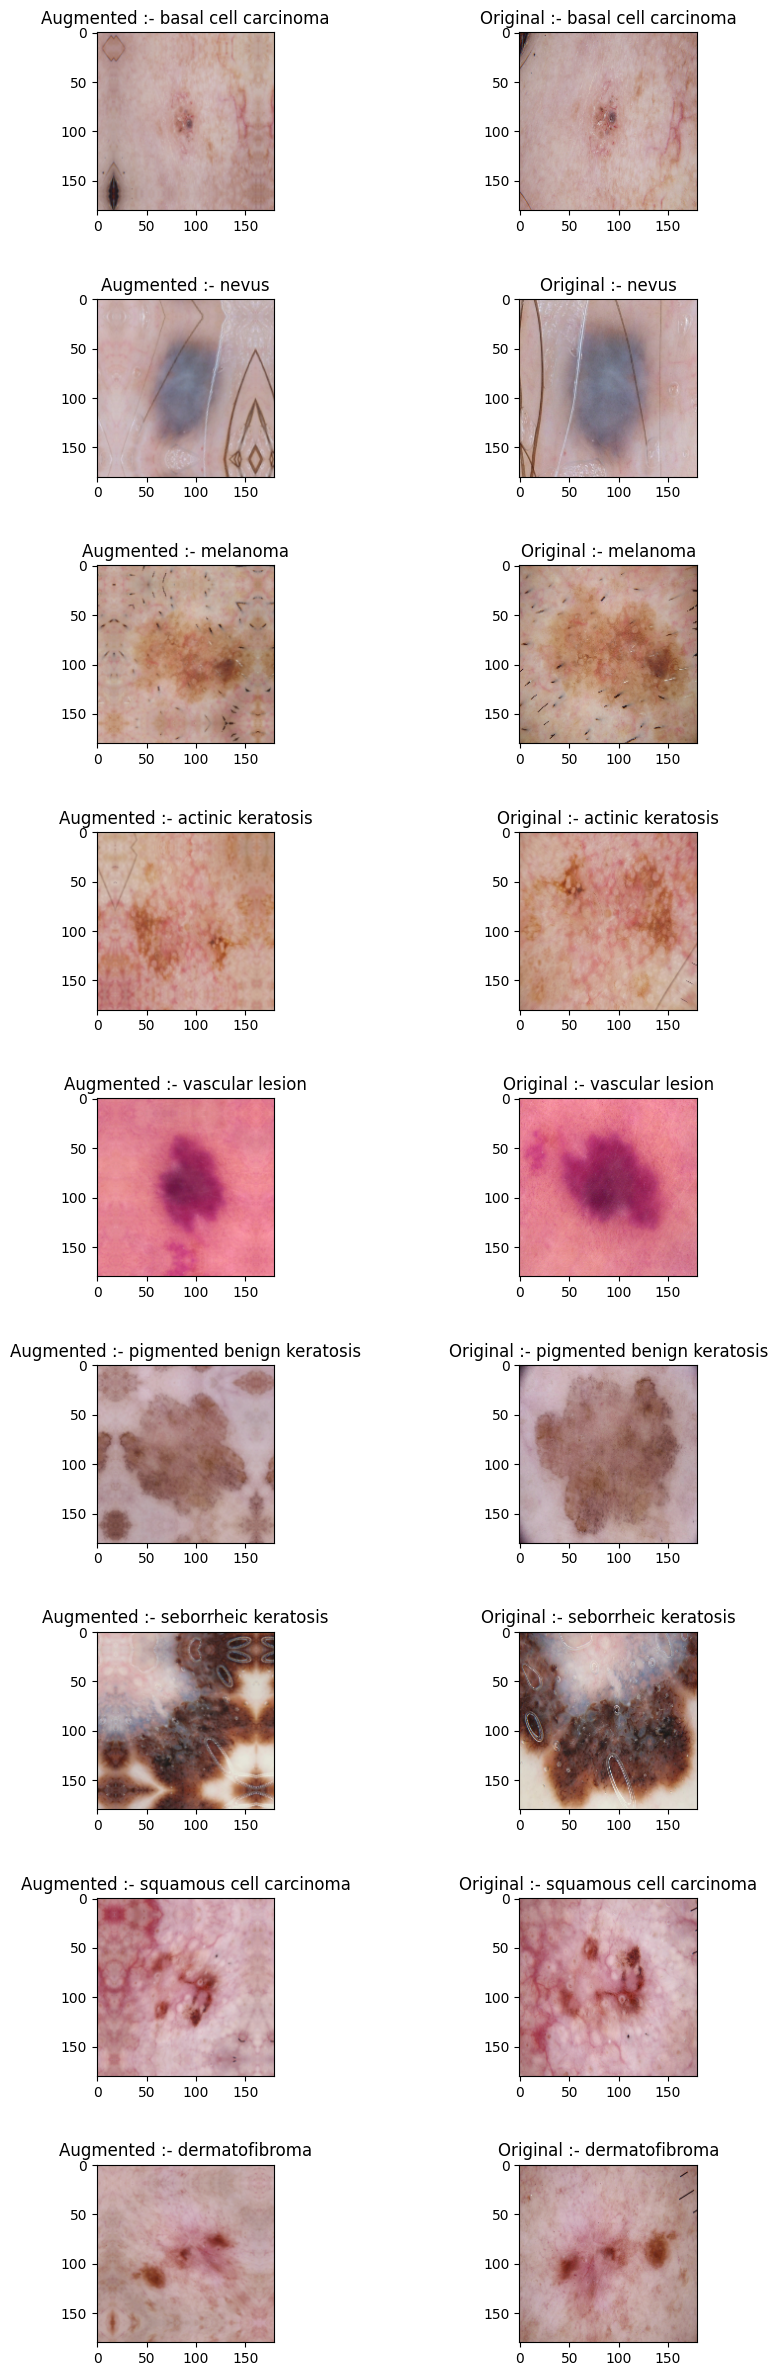

In [ ]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here


plot_idx=0
visited={}
visited_all=False
plt.figure(figsize=(10,30))
for images, labels in train_ds.take(50):
  if not visited_all:
    for i in range(9):
    # print(images," | ",labels)
      # print(images.shape)
      # print(images[0].shape)
      # plt.figure(figsize=(20,20))
      if len(visited.keys())==9:
        visited_all=True
        break
      if class_names[labels[i]] in visited.keys():
        continue
      else:
        plt.subplots_adjust(hspace=0.5)
        plt.subplot(9,2,plot_idx+1)
        x=augumentation_var(images)
        plt.imshow(x[i].numpy().astype("uint8"));
        # plt.imshow(images[i].numpy().astype("uint8"));
        plt.title("Augmented :- "+class_names[labels[i]])
        plot_idx+=1
        plt.subplot(9,2,plot_idx+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title("Original :- "+class_names[labels[i]])
        visited[class_names[labels[i]]]="Y"
        plot_idx+=1

  else:
    break


# Do all the possible playing with Hyperparameters to get the best model. See if you can get a model which
# is not overfitting or underfitting
# Write down proper insights about your model

### Todo:
### Create the model, compile and train the model


In [ ]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
## Your code goes here

model2_augumentation = Sequential([
         layers.Rescaling(1./255,input_shape=(img_height,img_width,3)),
         augumentation_var,
         layers.Conv2D(16,3,padding='same',activation="relu"),
         layers.MaxPool2D((2,2),strides=2),
         layers.Conv2D(32,3,padding='same',activation="relu"),
         layers.MaxPool2D((2,2),strides=2),
         layers.Conv2D(64,3,padding='same',activation="relu"),
         layers.MaxPool2D((2,2),strides=2),
         layers.Flatten(),
         layers.Dense(128,activation="relu"),
         layers.Dense(num_classes)
])


### Compiling the model

In [ ]:
## Your code goes here
model2_augumentation.compile(optimizer="adam",loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics = ['accuracy'])
# model2_augumentation.compile(optimizer="adam",loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics = ['accuracy'])

### Training the model

In [ ]:
## Your code goes here, note: train your model for 20 epochs
#train the model : run the model on train & validation set
epochs = 30
history = model2_augumentation.fit( train_ds , validation_data= val_ds , epochs = epochs)

Epoch 1/30
56/56 [==============================] - 4s 31ms/step - loss: 2.0290 - accuracy: 0.2427 - val_loss: 1.8106 - val_accuracy: 0.3445
Epoch 2/30
56/56 [==============================] - 1s 25ms/step - loss: 1.7276 - accuracy: 0.3862 - val_loss: 2.0240 - val_accuracy: 0.3579
Epoch 3/30
56/56 [==============================] - 1s 23ms/step - loss: 1.6287 - accuracy: 0.4297 - val_loss: 1.8481 - val_accuracy: 0.3602
Epoch 4/30
56/56 [==============================] - 1s 23ms/step - loss: 1.5182 - accuracy: 0.4671 - val_loss: 1.4529 - val_accuracy: 0.5056
Epoch 5/30
56/56 [==============================] - 1s 23ms/step - loss: 1.4347 - accuracy: 0.4927 - val_loss: 1.4629 - val_accuracy: 0.5034
Epoch 6/30
56/56 [==============================] - 1s 23ms/step - loss: 1.3655 - accuracy: 0.5246 - val_loss: 1.5240 - val_accuracy: 0.4787
Epoch 7/30
56/56 [==============================] - 1s 23ms/step - loss: 1.3647 - accuracy: 0.5229 - val_loss: 1.3640 - val_accuracy: 0.5414
Epoch 8/30
56

### Visualizing the results

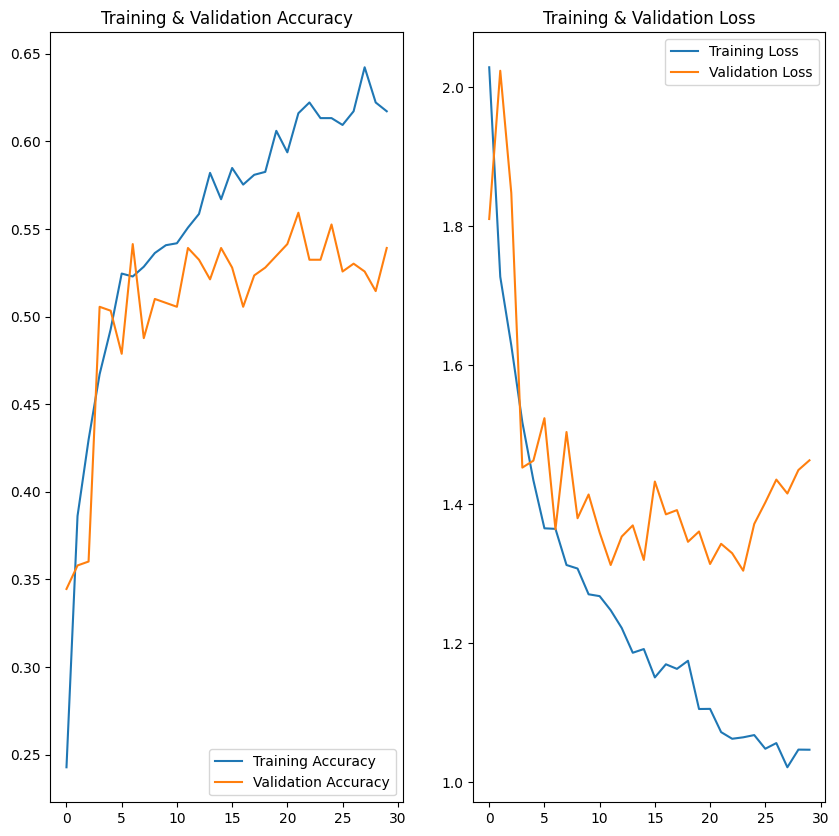

In [ ]:
show_accuracy_pattern(history)

#### Todo: The model is still overfitting. But there is slight reduction in accuracy gap

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?


## **Todo:** Handling class imbalances:
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
path_to_training_dataset="/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)  #Adding 500 samples per class to make sure that none of the classes are sparse

Initialised with 114 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x790B38F94190>: 100%|██████████| 500/500 [00:16<00:00, 31.05 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x790BB1DB7460>: 100%|██████████| 500/500 [00:15<00:00, 32.12 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x790B38FDA860>: 100%|██████████| 500/500 [00:15<00:00, 31.53 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x790B38F73040>: 100%|██████████| 500/500 [01:27<00:00,  5.73 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=2012x1956 at 0x790BCC400FD0>: 100%|██████████| 500/500 [01:20<00:00,  6.18 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x790B38FDB8B0>: 100%|██████████| 500/500 [00:15<00:00, 31.94 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x790BB1DB6EC0>: 100%|██████████| 500/500 [00:39<00:00, 12.69 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x790C531D6FB0>: 100%|██████████| 500/500 [00:16<00:00, 29.86 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x790BCCD78190>: 100%|██████████| 500/500 [00:15<00:00, 31.45 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
#Count total number of image generated by Augmentor.
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [ ]:
# train dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size=32,
                                                               image_size=(180,180), label_mode='categorical',
                                                               seed=123,subset="training",
                                                               validation_split=0.2)

#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes),
#representing a one-hot encoding of the class index.

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [ ]:
# validation dataset
val_ds =tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,
                                                            image_size=(180,180), label_mode='categorical',
                                                            seed=123,subset="validation",
                                                            validation_split=0.2)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [ ]:
#CNN Model Architecture

#Sequential allows you to create models layer-by-layer

model4_augumentation = Sequential()
model4_augumentation.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer
#First Convulation layer
model4_augumentation.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model4_augumentation.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model4_augumentation.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model4_augumentation.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model4_augumentation.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model4_augumentation.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model4_augumentation.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model4_augumentation.add(layers.Flatten())

#Dense Layer
model4_augumentation.add(layers.Dense(128,activation='relu'))
# model4_augumentation.add(layers.Dense(256,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model4_augumentation.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model4_augumentation.add(layers.Dense(len(class_names),activation='softmax'))



#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [ ]:
#Compile the Model

#Adam optimization: is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
#categorical_crossentropy: Used as a loss function for multi-class classification model where there are two or more output labels.

model4_augumentation.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

#ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,
#so the model or weights can be loaded later to continue the training from the state saved.
checkpoint = ModelCheckpoint("model.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

#Stop training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)

#### **Todo:**  Train your model

In [ ]:
# Train the model
epochs = 30
# history = model4_augumentation.fit(train_ds, validation_data=val_ds, epochs=epochs,callbacks=[checkpoint,earlystop])
history = model4_augumentation.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=[checkpoint])


Epoch 1/30
168/169 [============================>.] - ETA: 0s - loss: 1.8696 - accuracy: 0.2753
Epoch 1: val_accuracy improved from -inf to 0.36897, saving model to model.h5
169/169 [==============================] - 32s 172ms/step - loss: 1.8690 - accuracy: 0.2758 - val_loss: 1.6891 - val_accuracy: 0.3690
Epoch 2/30
168/169 [============================>.] - ETA: 0s - loss: 1.5016 - accuracy: 0.4256
Epoch 2: val_accuracy improved from 0.36897 to 0.49369, saving model to model.h5
169/169 [==============================] - 30s 173ms/step - loss: 1.5022 - accuracy: 0.4256 - val_loss: 1.3559 - val_accuracy: 0.4937
Epoch 3/30
168/169 [============================>.] - ETA: 0s - loss: 1.3674 - accuracy: 0.4864
Epoch 3: val_accuracy improved from 0.49369 to 0.55308, saving model to model.h5
169/169 [==============================] - 29s 168ms/step - loss: 1.3678 - accuracy: 0.4855 - val_loss: 1.2072 - val_accuracy: 0.5531
Epoch 4/30
168/169 [============================>.] - ETA: 0s - loss: 

#### **Todo:**  Visualize the model results

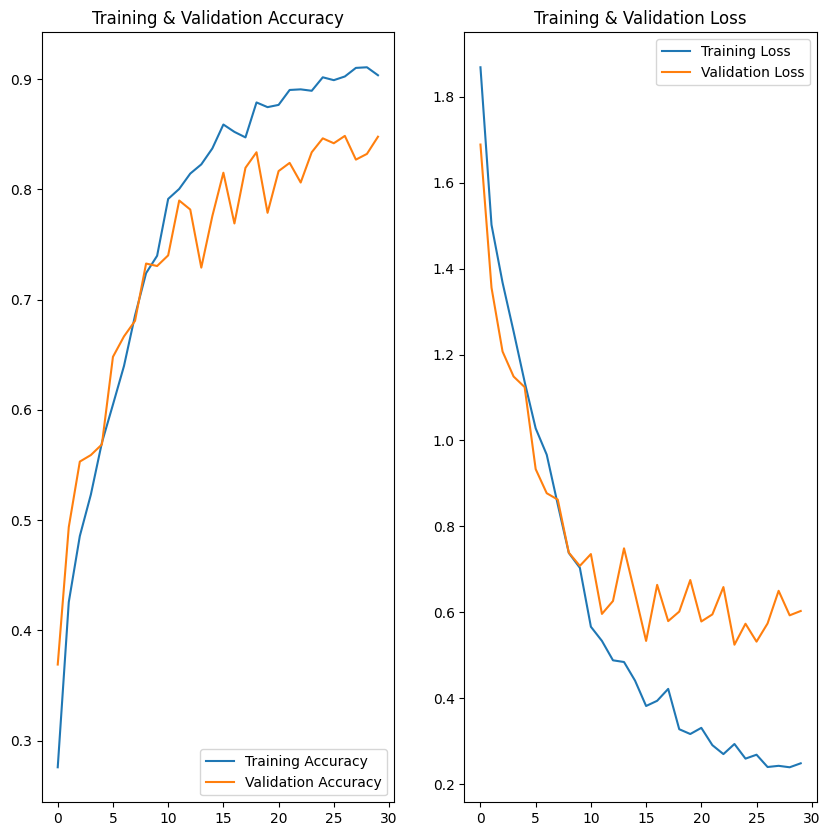

In [ ]:
show_accuracy_pattern(history)

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

<div style="color: #000000; background-color: #f7f7f7; font-family: monospace, Menlo, Monaco, 'Courier New', monospace; font-weight: normal; font-size: 14px; line-height: 19px; white-space: pre;">
<h3><span style="color: #000000;"><b>Analysis</b> : The model appears <strong>well-balanced</strong>, showing neither significant overfitting nor underfitting. </span></h3>
<div><span style="color: #000000;">With consistent improvement in validation accuracy and close alignment with training accuracy, the model generalizes effectively. </span></div>
<div><span style="color: #000000;">Evaluate final metrics on a test set for a comprehensive assessment.</span></div>
<div>&nbsp;</div>
</div>


In [ ]:
def test_model_prediction(model_name, expected="melanoma", melanoma_path = "Skin cancer ISIC The International Skin Imaging Collaboration/Test/melanoma/ISIC_0000013.jpg"):

    img = tf.keras.utils.load_img(
    melanoma_path, target_size=(img_height, img_width)
    )
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    predictions = model_name.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    # print(score)

    display(
    "Expected {}. Predicted {}:- with a {:.2f}%"
    .format(expected, test_ds.class_names[np.argmax(score)], 100 * np.max(score))
    )

    print("\n\n")



In [ ]:
test_model_prediction(model4_augumentation, melanoma_path = "Skin cancer ISIC The International Skin Imaging Collaboration/Test/melanoma/ISIC_0000013.jpg")

1/1 [==============================] - 0s 21ms/step


'Expected melanoma. Predicted nevus:- with a 25.36%'

1/1 [==============================] - 0s 20ms/step
Actual Class actinic keratosis
Predictive Class nevus
1/1 [==============================] - 0s 28ms/step
Actual Class basal cell carcinoma
Predictive Class basal cell carcinoma
1/1 [==============================] - 0s 21ms/step
Actual Class dermatofibroma
Predictive Class melanoma
1/1 [==============================] - 0s 19ms/step
Actual Class melanoma
Predictive Class nevus
1/1 [==============================] - 0s 19ms/step
Actual Class nevus
Predictive Class nevus
1/1 [==============================] - 0s 20ms/step
Actual Class pigmented benign keratosis
Predictive Class squamous cell carcinoma
1/1 [==============================] - 0s 22ms/step
Actual Class seborrheic keratosis
Predictive Class actinic keratosis
1/1 [==============================] - 0s 18ms/step
Actual Class squamous cell carcinoma
Predictive Class nevus
1/1 [==============================] - 0s 18ms/step
Actual Class vascular lesion
Predictive Class basal cel

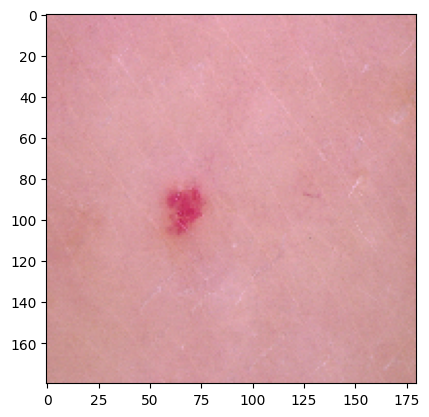

In [ ]:
from glob import glob
# class_trial = class_names[2]

for class_trial in class_names:
  Test_image_path = os.path.join(data_dir_test, class_trial, '*')
  Test_image = glob(Test_image_path)
  Test_image = load_img(Test_image[-1],target_size=(180,180,3))
  plt.imshow(Test_image)
  plt.grid(False)

  img = np.expand_dims(Test_image,axis=0)
  pred = model4_augumentation.predict(img)
  pred = np.argmax(pred)
  pred_class = class_names[pred]
  print("Actual Class "+ class_trial +'\n'+ "Predictive Class "+pred_class )
